In [14]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros([m, max_len])
    
    for i in range(m):                               # loop over training examples
        sentence_words =X[i].lower().split()
        j = 0
        for w in sentence_words:
            if w in word_to_index and j < max_len:
                X_indices[i, j] = word_to_index[w]
                j = j + 1
    return X_indices

In [16]:
def read_glove_vecs(file_path):
    index_to_word = []
    word_to_index = {}
    word_to_vec_map = {}
    index = 0
    with open(file_path, encoding="utf8") as f:
        for line in f:
            l = line.split()
            index_to_word.append(l[0])
            word_to_index[l[0]] = index
            word_to_vec_map[l[0]] = np.asarray(l[1:], dtype=np.float32)
            index += 1
    return word_to_index, index_to_word, word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.first.3.rows.txt')
# print(word_to_index, index_to_word, word_to_vec_map)

In [17]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50
    emb_matrix = np.zeros([vocab_len, emb_dim])
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [18]:
def EAT_category_pred(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices)   
    
    X = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embeddings)
    X = Dense(12)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

(array([  3.71000000e+02,   2.75450000e+04,   1.90680000e+04,
          2.62100000e+03,   3.20000000e+02,   5.50000000e+01,
          1.30000000e+01]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

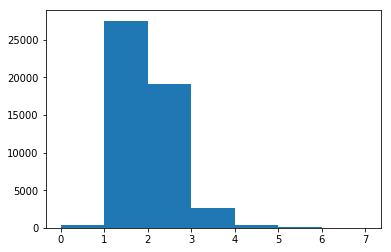

In [19]:
dfs = pd.read_excel("export.xlsx", sheetname=None)
df = dfs['EAI.TBLEVENT']
all_events_list = "ENVIRONMENTAL_EVENT	PERSONALSAFETY_EVENT	PROCESSSAFETY_EVENT	RELIABILITY_EVENT	SECURITY_EVENT	QUALITY_EVENT	AUDIT_EVENT	ASSESSMENT_EVENT	BEHAVIORTRENDS_EVENT	SUCCESSANALYSIS_EVENT	OTHERLEARNINGEXPERIENCE_EV	OTHERUNPLANNED_EVENT".split("	")
def get_sum_of_cat_per_row(row, event_list):
    sum = 0
    for event in event_list:
        sum += row[event]
    return -sum
df['sum_of_categories'] = df.apply(lambda row: get_sum_of_cat_per_row(row, all_events_list), axis=1)
plt.hist(df['sum_of_categories'], bins = [0, 1, 2, 3, 4, 5, 6, 7])

In [20]:
df = df.loc[df['sum_of_categories'] == 1]
df = df.sample(frac=1)
df = df
X_all = df['DESCRIPTION'].values.astype('U')
Y_all = -df.loc[:, all_events_list].values

(array([ 16268.,   5422.,   2536.,   1247.,    767.,    492.,    341.,
           209.,    154.,    109.]),
 array([   0. ,   36.4,   72.8,  109.2,  145.6,  182. ,  218.4,  254.8,
         291.2,  327.6,  364. ]),
 <a list of 10 Patch objects>)

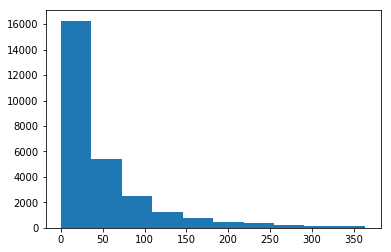

In [8]:
df['desc_len'] = df.apply(lambda row: len(str(row['DESCRIPTION']).split()), axis=1)
plt.hist(df['desc_len'])

In [9]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [10]:
maxLen = 80

In [11]:
model = EAT_category_pred((maxLen,), word_to_vec_map, word_to_index)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
_________________________________________________________________
activation_1 (Activation)    (None, 12)                0         
Total params: 20,093,246
Trainable params: 93,196
Non-trainable params: 20,000,050
_________________________________________________________________


In [21]:
train_data_ratio = 0.7
split_index = int(train_data_ratio * len(X_all))
X_train, Y_train, X_test, Y_test = X_all[0:split_index], Y_all[0:split_index], X_all[split_index:], Y_all[split_index:]
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
# Y_train = convert_to_one_hot(Y_train, C = 5)

In [22]:
model.fit(X_train_indices, Y_train, epochs = 10, batch_size = 64, shuffle=True)

Epoch 1/10
19281/19281 [==============================] - 62s 3ms/step - loss: 1.5135 - acc: 0.4329
Epoch 2/10
19281/19281 [==============================] - 60s 3ms/step - loss: 1.5080 - acc: 0.4378
Epoch 3/10
19281/19281 [==============================] - 67s 3ms/step - loss: 1.5081 - acc: 0.4379
Epoch 4/10
19281/19281 [==============================] - 63s 3ms/step - loss: 1.5090 - acc: 0.4372
Epoch 5/10
19281/19281 [==============================] - 60s 3ms/step - loss: 1.5082 - acc: 0.4377
Epoch 6/10
19281/19281 [==============================] - 62s 3ms/step - loss: 1.5071 - acc: 0.4378
Epoch 7/10
19281/19281 [==============================] - 62s 3ms/step - loss: 1.5075 - acc: 0.4378
Epoch 8/10
19281/19281 [==============================] - 63s 3ms/step - loss: 1.5074 - acc: 0.4378
Epoch 9/10
19281/19281 [==============================] - 67s 3ms/step - loss: 1.5075 - acc: 0.4378
Epoch 10/10
19281/19281 [==============================] - 61s 3ms/step - loss: 1.5075 - acc: 0.4378

In [ ]:
# rand_indices = np.random.choice(19281, 5000)
# X_test = X_all[rand_indices]
# Y_test = Y_all[rand_indices]
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
loss, acc = model.evaluate(X_test_indices, Y_test)
# loss, acc = model.evaluate(X_train_indices, Y_train)
print("Test accuracy =", acc)

In [ ]:
# model.save("keras-RNN-len40-acc7407.h5")

Improvement ideas:
* clean the data
* get more data
* change the hyperparameters (though not much difference with 1 or 2 LSTM layers)